In [1]:
import datetime


def get_history_url(board, date, start=0, limit=100):
    return (
        f'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/{board}/securities.csv'
        f'?date={date:%Y-%m-%d}'
        f'&start={start:d}&limit={limit:d}'
        '&iss.only=history'
        '&history.columns=SECID,VALUE'
        '&numtrades=0'
        '&tradingsession=3'
    )


In [2]:
TODAY = datetime.date(2023, 4, 21)

get_history_url('TQBR', TODAY)


'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities.csv?date=2023-04-21&start=0&limit=100&iss.only=history&history.columns=SECID,VALUE&numtrades=0&tradingsession=3'

In [3]:
import pandas as pd


def get_history_data(board, date):
    start = 0
    limit = 100
    page_list = []

    while True:
        url = get_history_url(board, date, start, limit)
        page = pd.read_csv(url, delimiter=';', skiprows=2)
        row_count = len(page.index)

        if row_count > limit:
            raise Exception('Многовато будет...')

        page_list.append(page)

        if row_count < limit:
            break

        start += limit

    return pd.concat(page_list, ignore_index=True)


In [4]:
pd.options.display.float_format = lambda x: f'{x:1,.0f}'

get_history_data('TQBR', TODAY)

,SECID,VALUE
0,ABRD,"144,400,245"
1,ACKO,0
2,AFKS,"286,117,499"
3,AFLT,"1,729,189,474"
4,AGRO,"74,717,837"
...,...,...
240,YNDX,"2,574,409,843"
241,YRSB,"186,640"
242,YRSBP,"1,122,015"
243,ZILL,"24,782,040"


In [5]:
from pathlib import Path

CACHE_DIR = Path.joinpath(
    Path.home(), '.cache',
    'io.github.alekseymartynov',
    'notebooks/moex-liquidity'
)

if not CACHE_DIR.exists():
    CACHE_DIR.mkdir(parents=True)


In [6]:
def get_cache_file_path(board, date):
    return CACHE_DIR.joinpath(f'{board}-{date:%Y%m%d}')

In [7]:
def enumerate_history_dates():
    for d in range(365):
        yield TODAY + datetime.timedelta(days=-d)

In [8]:
def ensure_history_cached(board):
    count = 0
    for d in enumerate_history_dates():
        cache_file_path = get_cache_file_path(board, d)
        if not cache_file_path.exists():
            temp_file_path = cache_file_path.with_suffix('.tmp')
            get_history_data(board, d).to_csv(temp_file_path, index=False)
            temp_file_path.rename(cache_file_path)
        count += 1
    print(f'{count} files in cache')


In [9]:
ensure_history_cached('TQBR')

365 files in cache


In [10]:
import numpy as np


def build_report(board):
    dict = {}

    for d in enumerate_history_dates():
        frame = pd.read_csv(get_cache_file_path(board, d))
        for ticker, value in frame.itertuples(index=False, name=None):
            list = dict.setdefault(ticker, [])
            list.append(value)

    report = []

    for ticker, list in dict.items():
        report.append([
            ticker,
            np.median(list),
            min(list)
        ])

    report.sort(key=lambda row: row[2], reverse=True)

    return pd.DataFrame(report, columns=['ticker', 'median', 'min'])


In [11]:
report_TQBR = build_report('TQBR')
report_TQBR.head(50)

,ticker,median,min
0,SBER,"7,291,711,897","1,504,730,792"
1,GAZP,"4,285,222,662","849,778,960"
2,LKOH,"1,888,889,272","482,759,286"
3,GMKN,"1,187,107,843","463,298,528"
4,ROSN,"986,826,194","327,513,783"
5,NVTK,"988,369,176","286,754,474"
6,MGNT,"644,161,816","197,520,972"
7,PLZL,"1,243,390,259","186,162,128"
8,VTBR,"598,904,330","178,831,080"
9,SBERP,"623,479,264","158,599,253"


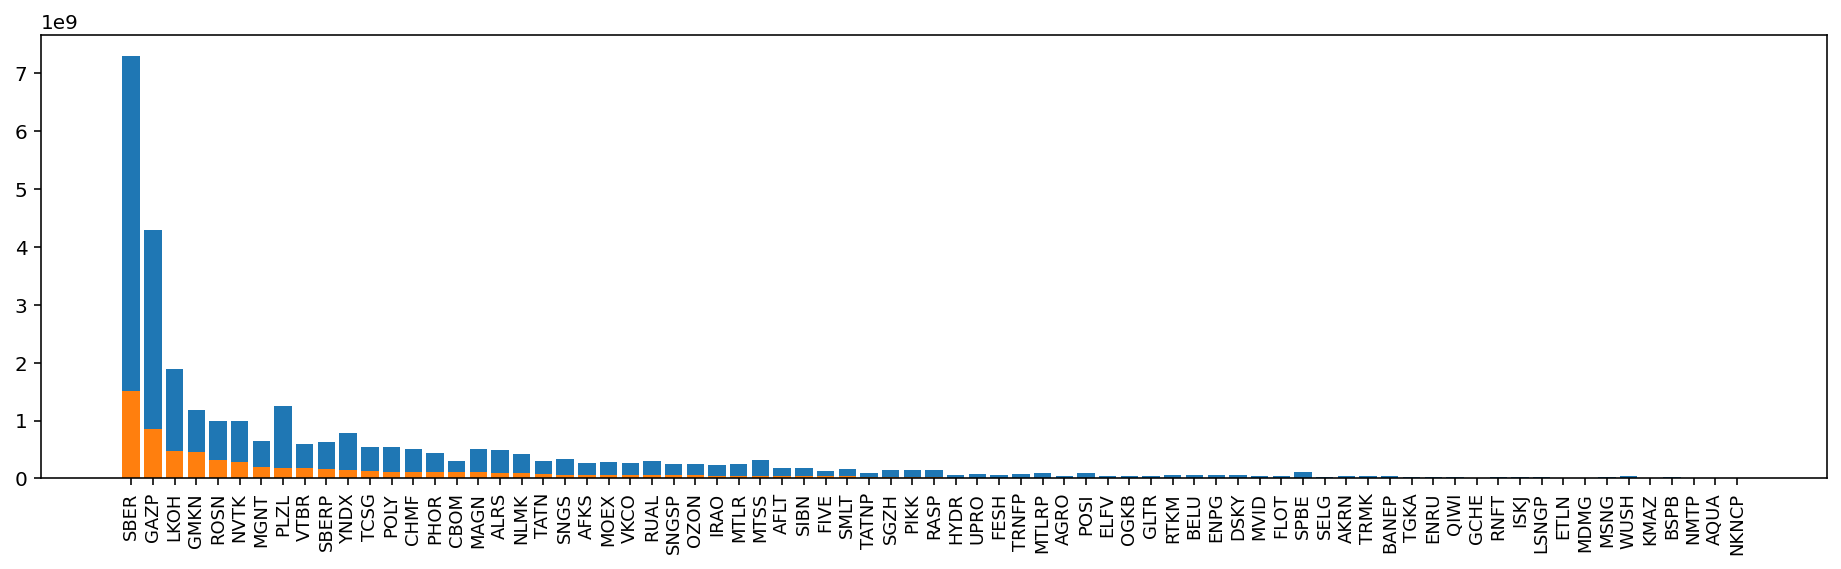

In [12]:
from matplotlib import pyplot as plt

BAR_COUNT = 75

plt.figure(figsize=(16, 4), dpi=144)
plt.bar(
    report_TQBR['ticker'][:BAR_COUNT],
    report_TQBR['median'][:BAR_COUNT],
)
plt.bar(
    report_TQBR['ticker'][:BAR_COUNT],
    report_TQBR['min'][:BAR_COUNT],
)
# plt.yscale('log')
plt.xticks(rotation=90, fontsize=9, va='top')
plt.show()


In [13]:
ensure_history_cached('TQTF')

365 files in cache


In [14]:
build_report('TQTF').head(50)

,ticker,median,min
0,TRUR,"357,269,424","192,102,081"
1,LQDT,"248,385,468","98,447,023"
2,VTBM,"174,286,262","92,331,230"
3,TMOS,"59,336,899","16,655,352"
4,VTBG,"42,660,712","15,381,308"
5,VTBX,"24,401,319","9,382,080"
6,EQMX,"21,740,752","6,203,908"
7,GOLD,"28,382,661","4,852,070"
8,TBRU,"22,678,632","4,347,469"
9,SBMX,"22,990,328","4,317,132"
